In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def streaming_operator(f_inm, c_ai):

    '''streaming'''
    for i in range(9):
        f_inm[i] = np.roll(f_inm[i], shift=c_ai.T[i], axis=(0, 1))
    ''''''
    return f_inm

def feq(rho_nm, u_anm, c_ai, w_i):

    '''c * u'''
    cu_nm = np.einsum('ai,anm->inm', c_ai, u_anm)
    ''''''

    '''squaring cu'''
    sqcu_nm = cu_nm**2
    ''''''

    '''scalar product of the velocity vectors with itself at each lattice side'''
    usq_nm = np.einsum('anm,anm->nm', u_anm, u_anm)
    ''''''

    '''equilibrium distribution'''
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    ''''''

    '''calculating equivalent probability density function'''
    feq_inm = wrho_inm * (1 + 3 * cu_nm + 4.5 * sqcu_nm - 1.5 * usq_nm)
    ''''''

    return feq_inm

def feq_limited(rho_nm, u_anm, c_ai, w_i):
    '''c * u'''
    cu_nm = (u_anm.T @ c_ai).T
    ''''''

    '''squaring cu'''
    sqcu_nm = cu_nm**2
    ''''''

    '''scalar product of the velocity vectors with itself at each lattice side'''
    usq_nm = np.linalg.norm(u_anm, axis=0)**2
    ''''''

    return w_i[..., np.newaxis] * rho_nm[np.newaxis, ...] * (1. + 3. * cu_nm + 4.5 * sqcu_nm - 1.5 * usq_nm[np.newaxis, ...])

def collision(f_inm, c_ai, w_i, omega):

    '''calculating density from pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    ''''''

    '''calculating average velocity'''
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm) / rho_nm
    ''''''

    '''calculating equilibrium probability density function'''
    feq_ixy = feq(rho_nm, u_anm, c_ai, w_i)
    ''''''

    return (f_inm + (omega * (feq_ixy - f_inm))), u_anm

def rigid_wall(f_inm, rho_nm, c_ai, grid_x, grid_y):

    '''index_rigid stores directions bottom, bottom-left and bottom-right and the mirrored directions in opposite[]'''
    index_rigid = np.array([4, 7, 8])
    opposite_rigid = np.array([2, 5, 6])
    ''''''

    '''copying probability density function to a dummy variable'''
    f_inm_dummy = np.empty_like(f_inm)

    for i in range(9):
        for j in range(grid_x):
            for k in range(grid_y):
                f_inm_dummy[i, j, k] = f_inm[i, j, k]
    ''''''

    '''performing an inital streaming operation to update the probability density function'''
    f_inm = streaming_operator(f_inm, c_ai)
    ''''''

    rho_nm = np.einsum('ijk->jk', f_inm)

    for i in range(9):

        '''checking if we are in channels 4, 7, or 8'''
        if i in index_rigid:

            '''rigid wall boundary condition'''
            f_inm[opposite_rigid[np.where(i == index_rigid)[0][0]], -1, :] = f_inm_dummy[i, -1, :]
            ''''''

    '''Calulating density and velocity using pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm)
    ''''''

    return f_inm, rho_nm, u_anm

In [3]:
def pressure_variation(f_inm, rho_nm, u_anm, c_ai, w_i, grid_x, grid_y, in_out_density: list|np.ndarray):

    '''derive density matrix and initialize boundary densities'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    rho_in = np.full(grid_x, in_out_density[0])
    rho_out = np.full(grid_x, in_out_density[1])
    ''''''

    '''storing indices for each direction'''
    index_bottom = np.array([4, 7, 8])
    opposite_bottom = np.array([2, 5, 6])
    index_top = np.array([2, 5, 6])
    opposite_top = np.array([4, 7, 8])
    ''''''

    '''checking velocity at boundaries'''
    u_in = u_anm[:, :, 1]
    u_out = u_anm[:, :, -2]

    '''calculate inlet pdf'''
    f_eq_in = feq_limited(rho_in, u_out, c_ai, w_i)
    f_int_beg = f_inm[:, :, -2] - feq_limited(rho_nm[:, -2], u_out, c_ai, w_i)
    f_inm[:, :, 0] = f_eq_in + f_int_beg

    '''calculating outlet pdf'''
    f_eq_out = feq_limited(rho_out, u_in, c_ai, w_i)
    f_int_end = f_inm[:, :, 1] - feq_limited(rho_nm[:, 1], u_in, c_ai, w_i)
    f_inm[:, :, -1] = f_eq_out + f_int_end
    ''''''

    '''copying pdf to a dummy variable'''
    f_inm_dummy = np.empty_like(f_inm)

    for i in range(9):
        for j in range(grid_x):
            for k in range(grid_y):
                f_inm_dummy[i, j, k] = f_inm[i, j, k]
    ''''''

    '''streaming'''
    f_inm = streaming_operator(f_inm, c_ai)
    ''''''

    '''rigid wall condition'''
    for i in range(9):

        '''checking if we are in channels 4, 7, or 8'''
        if i in index_bottom:

            '''rigid wall boundary condition'''
            f_inm[opposite_bottom[np.where(i == index_bottom)[0][0]], -1, :] = f_inm_dummy[i, -1, :]
            ''''''

        '''checking if we are in channels 2, 5, or 6'''
        if i in index_top:

            '''rigid wall boundary condition'''
            f_inm[opposite_top[np.where(i == index_top)[0][0]], -1, :] = f_inm_dummy[i, 0, :]
    ''''''


    '''Calulating density and velocity using pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm)
    ''''''
    
    return f_inm, rho_nm, u_anm

In [4]:
time_steps = 10000
grid_x, grid_y = 50, 50
grid_y += 2
omega = 1.0
epsilon = 0.1
rho_in_out = np.array([1.005, 0.995])

In [5]:
'''setting up initial density values'''
rho_nm = np.ones((grid_x, grid_y))
''''''

'''setting up initial velocity values'''
u_anm = np.zeros((2, grid_x, grid_y))
''''''

'''setting up weights'''
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
''''''

c_ai = np.array([[ 0,  0, -1,  0,  1, -1, -1,  1,  1],
                 [ 0,  1,  0, -1,  0,  1, -1, -1,  1]])

measurement_point = (grid_x)//2
velocity_field = np.empty((time_steps+1, 2, grid_x, grid_y))
velocity_field[0] = u_anm

# f_inm = np.einsum('i,jk -> ijk', w_i, rho_nm)

In [6]:
'''calculating initial equilibrium pdf'''
f_inm = feq(rho_nm, u_anm, c_ai, w_i)
''''''

'''calculating initial pdf after collision'''
f_inm, u_anm = collision(f_inm, c_ai, w_i, omega)
''''''

'''Deriving average density and velocity after collision'''
rho_nm = np.einsum('ijk -> jk', f_inm)
''''''

'''applying pressure gradient'''
f_inm, rho_nm, u_anm = pressure_variation(f_inm, rho_nm, u_anm, c_ai, w_i, grid_x, grid_y, rho_in_out)
''''''

for i in range(time_steps):
    
    '''calculating subsequent collision pdf'''
    f_inm, u_anm = collision(f_inm, c_ai, w_i, omega)
    ''''''

    velocity_field[i+1] = u_anm
    '''Deriving density matrix after collision'''
    
    rho_nm = np.einsum('ijk -> jk', f_inm)
    ''''''

    '''applying boundary conditions'''
    f_inm, rho_nm, u_anm = pressure_variation(f_inm, rho_nm, u_anm, c_ai, w_i, grid_x, grid_y, rho_in_out)
    ''''''

#### Plot

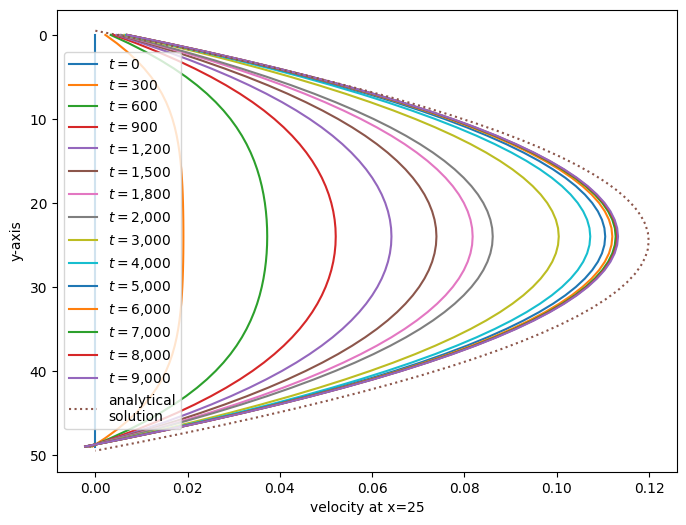

In [30]:
measurement_point = grid_x//2
viscosity = 1/3 * (1/omega - 0.5)

fig, ax = plt.subplots(figsize=(8, 6))
ax.invert_yaxis()
ax.set_xlabel(f"velocity at x={measurement_point}")
ax.set_ylabel("y-axis")

y_data = np.arange(grid_x)

for t in range(time_steps):
    if t < 2000:
        if t % 300 == 0:
            x_data = velocity_field[t, 1, :, measurement_point]
            ax.plot(x_data, y_data, label=f"$t=${t:,}")
    elif t >= 200:
        if t % 1000 == 0:
            x_data = velocity_field[t, 1, :, measurement_point]
            ax.plot(x_data, y_data, label=f"$t=${t:,}")

'''plotting analytical solution'''
y_data = np.append(y_data, grid_x)

'''calculating pressure derivative'''
pressure_der = (rho_in_out[1] - rho_in_out[0]) / 3.0 / grid_y

'''calculating dynamic viscosity as per the formula'''
dynamic_viscosity = viscosity * rho_nm[:, measurement_point].mean()

analytical = - 0.5 / dynamic_viscosity * pressure_der * y_data * (grid_x - y_data)
ax.plot(analytical, y_data-0.5, linestyle="dotted", label="analytical\nsolution")

ax.legend()
plt.show()


#### Flow Field

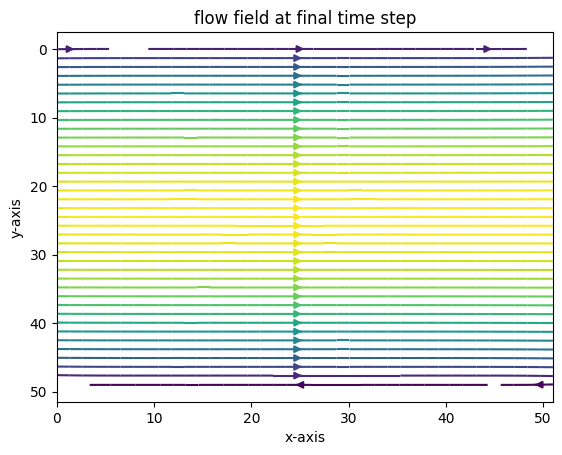

In [38]:
fig, ax = plt.subplots()
ax.set_ylabel("y-axis")
ax.set_xlabel("x-axis")
x, y, v, u = np.arange(grid_y), np.arange(grid_x), velocity_field[-1, 0], velocity_field[-1, 1]
plt.streamplot(x, y, u, v, color=u, density=1.3)
ax.set_title("flow field at final time step")
ax.invert_yaxis()
plt.show()

#### Density Across Center

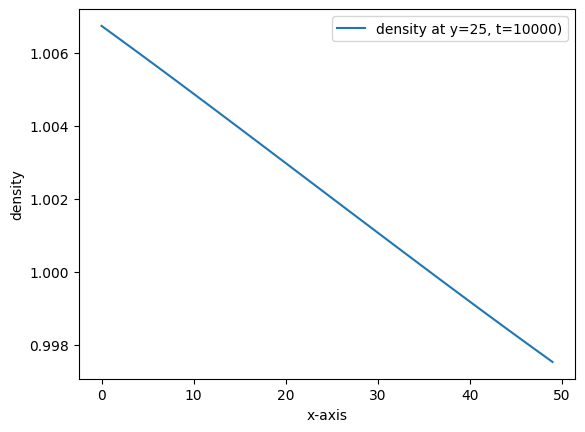

In [40]:
plt.figure()
plt.xlabel("x-axis")
plt.ylabel("density")
plt.plot(rho_nm[grid_x//2, 1:-1], label=f"density at y={grid_x//2}, t={time_steps})")
plt.legend()
plt.show()

#### Velocity Profile

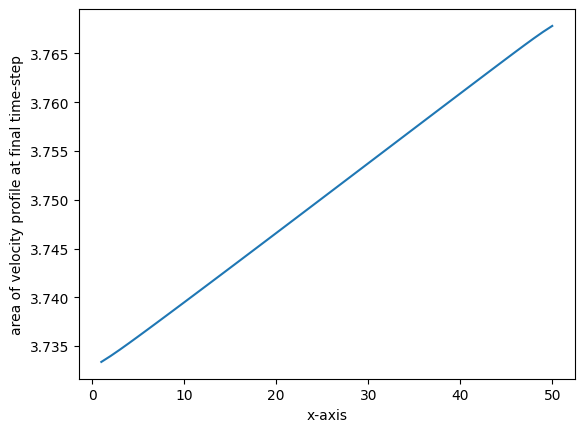

Increase in area:  0.9224500191579388


In [49]:
plt.figure()
plt.xlabel("x-axis")
plt.ylabel("area of velocity profile at final time-step")
x_data = np.arange(1, grid_y-1)
y_data = np.array([np.sum(velocity_field[time_steps, 1, :, x]) for x in x_data])
plt.plot(x_data, y_data)
plt.show()
area = (y_data[-1] / y_data[0] - 1) * 100
print("Increase in area: ", area)